<a href="https://colab.research.google.com/github/ashhabk/serverless-redshift-analytics/blob/main/redshift_colab_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎟️ Redshift Ticket Sales Analysis (via Google Colab)
This portfolio notebook demonstrates how to connect to **Amazon Redshift Serverless** using Python, run analytical queries, and visualize the results with **pandas** and **matplotlib**.

We will analyze the `tickit` dataset and uncover top events by total revenue.

## 🔌 Step 1: Install Required Libraries
We’ll use the `boto3` SDK to access Amazon Redshift **Data API**, which works without needing `psycopg2` or `sqlalchemy`.
It’s the cleanest way to run Redshift queries from Colab.

In [1]:
!pip install boto3 pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 6.6 MB/s eta 0:00:00


## 🔐 Step 2: Configure AWS Access (Temporary Credentials)
You’ll need an IAM user with access to Redshift Data API. For this demo, use temporary credentials via AWS CLI, or use IAM role if running from SageMaker.

```python
import boto3
import pandas as pd
import matplotlib.pyplot as plt

# Fill in your own credentials securely (NEVER expose in public notebooks)
client = boto3.client('redshift-data', region_name='ap-southeast-1',
    aws_access_key_id='YOUR_KEY',
    aws_secret_access_key='YOUR_SECRET')
```

## 🧠 Step 3: Define Helper Function to Run SQL Queries
Redshift Data API requires running statements, checking their status, and fetching results.

In [3]:
import time
def run_redshift_query(sql, database='sample_data_dev', workgroup='default-workgroup'):
    response = client.execute_statement(
        WorkgroupName=workgroup,
        Database=database,
        Sql=sql
    )
    query_id = response['Id']

    while True:
        status = client.describe_statement(Id=query_id)
        if status['Status'] in ['FINISHED', 'FAILED']:
            break
        time.sleep(1)

    if status['Status'] == 'FAILED':
        raise Exception('Query failed')

    result = client.get_statement_result(Id=query_id)
    columns = [col['name'] for col in result['ColumnMetadata']]
    rows = [[val.get('stringValue', '') for val in row] for row in result['Records']]
    return pd.DataFrame(rows, columns=columns)

## 📊 Step 4: Query Top 10 Events by Revenue

In [4]:
sql = '''
SELECT e.eventname, SUM(s.qtysold * s.pricepaid) AS total_revenue
FROM tickit.sales s
JOIN tickit.listing l ON s.listid = l.listid
JOIN tickit.event e ON l.eventid = e.eventid
GROUP BY e.eventname
ORDER BY total_revenue DESC
LIMIT 10;
'''

df = run_redshift_query(sql)
df['total_revenue'] = df['total_revenue'].astype(float)
df

,eventname,total_revenue
0,Mamma Mia!,2828812.0
1,Spring Awakening,2427243.0
2,The Country Girl,2301179.0
3,Macbeth,2100306.0
4,Legally Blonde,2052601.0
5,Jersey Boys,1987245.0
6,Chicago,1929235.0
7,Spamalot,1775949.0
8,Hedda Gabler,1663298.0
9,Thurgood,1564617.0


## 📈 Step 5: Visualize the Top Events by Revenue

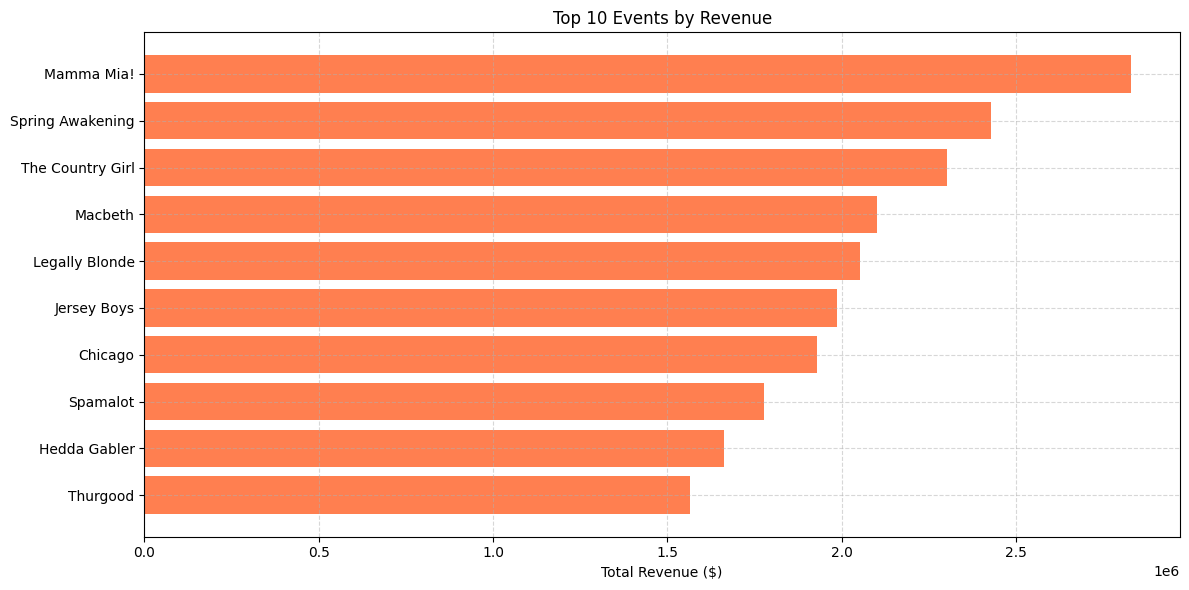

In [5]:
plt.figure(figsize=(12, 6))
plt.barh(df['eventname'], df['total_revenue'], color='coral')
plt.xlabel('Total Revenue ($)')
plt.title('Top 10 Events by Revenue')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 📈 Step 6 : Advanced Analysis 1: Revenue Trend Over Time
We’ll look at how total revenue changes over time across all events.

In [16]:
import plotly.express as px

sql = '''
SELECT d.caldate AS date, SUM(s.qtysold * s.pricepaid) AS daily_revenue
FROM tickit.sales s
JOIN tickit.listing l ON s.listid = l.listid
JOIN tickit.date d ON s.dateid = d.dateid
GROUP BY d.caldate
ORDER BY d.caldate;
'''

df_trend = run_redshift_query(sql)
df_trend['daily_revenue'] = df_trend['daily_revenue'].astype(float)
df_trend['date'] = pd.to_datetime(df_trend['date'])

fig = px.line(
    df_trend,
    x='date',
    y='daily_revenue',
    title='📆 Daily Revenue Trend Over Time',
    labels={'daily_revenue': 'Revenue ($)', 'date': 'Date'},
    template='plotly_white'  # ✨ cleaner look
)
fig.update_traces(line=dict(width=3, color='royalblue'))
fig.update_layout(
    margin=dict(t=50, b=30, l=30, r=30),
    title_font=dict(size=20),
    font=dict(size=14)
)
fig.show()



##📊 Step 7 : Advanced Analysis 2: Revenue by Event Category
This shows how different event categories (e.g., Concerts, Sports, Theater) contribute to total revenue.

In [17]:
sql = '''
SELECT c.catgroup, SUM(s.qtysold * s.pricepaid) AS total_revenue
FROM tickit.sales s
JOIN tickit.listing l ON s.listid = l.listid
JOIN tickit.event e ON l.eventid = e.eventid
JOIN tickit.category c ON e.catid = c.catid
GROUP BY c.catgroup
ORDER BY total_revenue DESC;
'''

df_cat = run_redshift_query(sql)
df_cat['total_revenue'] = df_cat['total_revenue'].astype(float)

fig = px.bar(
    df_cat,
    x='catgroup',
    y='total_revenue',
    title='🎭 Revenue by Event Category',
    text='total_revenue',
    labels={'catgroup': 'Category', 'total_revenue': 'Revenue ($)'},
    template='plotly_white'  # ✨ modern and clean
)
fig.update_traces(
    marker_color='orangered',
    texttemplate='%{text:.2s}',
    textposition='outside'
)
fig.update_layout(
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    yaxis_title='Revenue',
    xaxis_title='Category',
    title_font=dict(size=20),
    font=dict(size=14)
)
fig.show()


## ✅ Conclusion

This notebook demonstrates a complete, production-friendly workflow for data analysis using Amazon Redshift Serverless:

🔐 Secure connection using IAM-authenticated access via the Redshift Data API — no need for drivers or JDBC.

🧠 SQL-based analytics, leveraging Redshift’s performance with familiar query syntax.

📊 Clean visualizations using plotly.express, turning raw data into interactive, professional insights.

🧱 Serverless + Scalable: No infrastructure to manage, perfect for modern cloud-native data projects.

